## Install Packages

In [2]:
# !pip install --upgrade pip
# !pip install keras
# !conda remove wrapt -y
# !pip install tensorflow==2.2
# !pip install transformers
# !pip install torch
# !pip install numpy==1.16.0

In [3]:
from transformers import *
import pandas as pd
import torch
import sys
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tqdm import tqdm, trange
import time
import os, sys
from sklearn.utils import shuffle

Using TensorFlow backend.


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Set Random Seed

In [5]:
import random
def set_seed(seed):
    """ Set all seeds to make results reproducible (deterministic mode).
        When seed is a false-y value or not supplied, disables deterministic mode. """

    if seed:
        logging.info(f"Running in deterministic mode with seed {seed}")
        np.random.seed(seed)
        random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        os.environ['PYTHONHASHSEED'] = str(seed)
    else:
        logging.info(f"Running in non-deterministic mode")

## Load train, validation, test dataframe

In [43]:
base_dir = './dataset/'

import os 
import pandas as pd
import numpy as np
from copy import deepcopy

test_df = pd.read_csv(os.path.join(base_dir, 'test_dataset.csv'))
valid_df = pd.read_csv(os.path.join(base_dir, 'validation_dataset.csv'))
train_df = pd.read_csv(os.path.join(base_dir, 'train_dataset.csv'))

print('Training dataset:', train_df.shape)
print('Validation dataset:', valid_df.shape)
print('Test dataset:', test_df.shape)

Training dataset: (8644, 5)
Validation dataset: (500, 5)
Test dataset: (500, 5)


## Create train, validation, test dataloaders

In [7]:
def create_dataloader(df, batch_size, tokenizer, MAX_LEN = 512): 
    questions = df.question.values
    answers = df.answer.values
    labels = df.label.values
    labels_ = []
    for l in labels:
        if l == False:
            labels_.append(0)
        else:
            labels_.append(1)
    labels = labels_
    q_tokens_list = [tokenizer.tokenize(str(q)) for q in questions]
    a_tokens_list = [tokenizer.tokenize(str(a)) for a in answers]
    qas_tokens_list = list(zip(q_tokens_list, a_tokens_list))
    tokens_list = [[tokenizer.cls_token] + qas_token[0] + [tokenizer.sep_token] + qas_token[1][:MAX_LEN-3-len(qas_token[0])] + [tokenizer.sep_token] for qas_token in qas_tokens_list]
    input_ids = [tokenizer.convert_tokens_to_ids(tokens) for tokens in tokens_list]  
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
    attention_masks = []

    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    train_inputs = torch.tensor(input_ids) 
    train_labels = torch.tensor(labels) 
    train_masks = torch.tensor(attention_masks) 

    train_data = TensorDataset(train_inputs, train_masks, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    

    return train_dataloader

In [44]:
# sentence_data = {}
# def create_data(df, tokenizer, MAX_LEN = 512):
#     questions = df.question.values
#     answers = df.answer.values
#     labels = df.label.values
#     labels_ = []
#     for l in labels:
#         if l == False:
#             labels_.append(0)
#         else:
#             labels_.append(1)
#     labels = labels_
#     q_tokens_list = [tokenizer.tokenize(str(q)) for q in questions]
#     a_tokens_list = [tokenizer.tokenize(str(a)) for a in answers]
#     qas_tokens_list = list(zip(q_tokens_list, a_tokens_list))
#     tokens_list = [[tokenizer.cls_token] + qas_token[0] + [tokenizer.sep_token] + qas_token[1][:MAX_LEN-3-len(qas_token[0])] + [tokenizer.sep_token] for qas_token in qas_tokens_list]
#     input_ids = [tokenizer.convert_tokens_to_ids(tokens) for tokens in tokens_list]  
#     input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
#     attention_masks = []

#     for seq in input_ids:
#         seq_mask = [float(i>0) for i in seq]
#         attention_masks.append(seq_mask)
 
#     qas = [" ".join(qa) for qa in list(zip(questions, answers))]
#     for i, qa in enumerate(qas):
#         sent = qas[i]
#         input_id = input_ids[i]
#         label = labels[i]
#         attention_mask = attention_masks[i]
#         sentence_data[sent] = [input_id, label, attention_mask]
#     pickle.dump(sentence_data, open('sentence_data.pkl', 'wb'))
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')
# create_data(train_df, tokenizer)

In [46]:
sentence_data = pickle.load(open('sentence_data.pkl', 'rb'))

def load_dataloader(df, batch_size):
    questions = df.question.values
    answers = df.answer.values
    input_ids = []
    labels = []
    attention_masks = []
    qas = [" ".join(qa) for qa in list(zip(questions, answers))]
    for i, qs in enumerate(qas):
        data = sentence_data[qs]
        input_id = data[0]
        label = data[1]
        attention_mask = data[2]
        input_ids.append(input_id)
        labels.append(label)
        attention_masks.append(attention_mask)
    
    train_inputs = torch.tensor(input_ids) 
    train_labels = torch.tensor(labels) 
    train_masks = torch.tensor(attention_masks) 

    train_data = TensorDataset(train_inputs, train_masks, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    
    return train_dataloader

In [8]:
# tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')
bs = 8
valid_dataloader = create_dataloader(valid_df, bs, tokenizer)
test_dataloader = create_dataloader(test_df, bs, tokenizer)

## Create evaluation metrics

In [9]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [10]:
def f1_score_Luna(preds, y):
    predictions = np.argmax(preds, axis=1).flatten()
    labels = y.flatten()
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    for i in range(len(predictions)):
        p = predictions[i]
        l = labels[i]
        if p == l:
            if p == 1:
                TP += 1
            else:
                TN += 1
        else:
            if p == 1:
                FP += 1
            else:
                FN += 1
                
    if TP + FP != 0:
        p = float(TP)/(TP+FP)
    else:
        p = 0
    if TP + FN != 0:
        r = float(TP)/(TP+FN)
    else:
        r = 0
    if p == 0 or r == 0:
        f = 0
    else:
        f = 2 * (p*r)/(p+r)
    return f

## Create training process

In [11]:
def start_train(model, epoch, lr, train_dataloader, validation_dataloader):
    model.train()
    
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
        ]
    optimizer = AdamW(optimizer_grouped_parameters,
                 lr=lr,
                 correct_bias=False)    
        
    train_loss_list = []
    for _ in trange(epoch, desc="Epoch"):   
        for step, batch in enumerate(train_dataloader):     
            b_input_ids, b_input_mask, b_labels = batch
            b_input_ids = b_input_ids.cuda()
            b_input_mask = b_input_mask.cuda()
            b_labels = b_labels.cuda()
            optimizer.zero_grad()
            output = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            loss = output[0]
            train_loss_list.append(loss.item())
            if step % 10 == 0:
                print("Train Loss: ", loss.item())
                sys.stdout.flush()
            loss.backward()
            optimizer.step()
            
            if step % 100 == 0:
                model.eval()
                valid_loss_list = []
                accuracy_list = []
                f_list = []
                validate_start_time = time.time()
                for batch in validation_dataloader:
                    b_input_ids, b_input_mask, b_labels = batch
                    b_input_ids = b_input_ids.cuda()
                    b_input_mask = b_input_mask.cuda()
                    b_labels = b_labels.cuda()
                    with torch.no_grad():
                        output = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
                    loss = output[0]
                    logits = output[1].cpu().numpy()
                    label_ids = b_labels.cpu().numpy()
                    accur = flat_accuracy(logits, label_ids)
                    f = f1_score_Luna(logits, label_ids)
                    
                    valid_loss_list.append(loss.item())
                    accuracy_list.append(accur)
                    f_list.append(f)
                    
                                       
                print("Valid Loss: ", sum(valid_loss_list)/len(valid_loss_list))
                print("Valid Accuracy: ", sum(accuracy_list)/len(accuracy_list))
                print("Valid F Score: ", sum(f_list)/len(f_list))
                sys.stdout.flush()
    return model, optimizer

## Evaluate the trained model

In [12]:
def eval_dataset(model, dataloader):
    model.eval()
    set_seed(1)
    accuracy_list = []
    f_list = []
    logits_all = None
    flag = False

    for batch in dataloader:
        b_input_ids, b_input_mask, b_labels = batch
        b_input_ids = b_input_ids.cuda()
        b_input_mask = b_input_mask.cuda()
        b_labels = b_labels.cuda()
        with torch.no_grad():
            output = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = output[0]
        logits = output[1].cpu().numpy()
        label_ids = b_labels.cpu().numpy()
        if not flag:
            logits_all = logits
            flag = True
        else:
            logits_all = np.concatenate((logits_all, logits), axis=0)

        accur = flat_accuracy(logits, label_ids)
        f = f1_score_Luna(logits, label_ids)

        accuracy_list.append(accur)
        f_list.append(f)

    acc = sum(accuracy_list)/len(accuracy_list)
    f1 = sum(f_list)/len(f_list)
    
    return logits_all, acc, f1

## Active Learning Loop

### Random Strategy

In [13]:
def random_active_learner(data, b_size=10, seed=0):
    sampled = data.sample(n=b_size, random_state=seed)
    remaining = data.drop(sampled.index)

    return sampled, remaining

### Uncertainty-based AL

In [14]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def uncertainty_active_learner(data, b_size, probs):  
    # step 1: find the higher probability
    # step 2: sort these probabilities
    # step 3: choose the ones that have the lowest probability
    probs_softmax = []
    for p in probs:
        new_p = softmax(p)
        probs_softmax.append(new_p)
    sorted_arg = np.argsort(np.amax(probs_softmax, axis=1))
    
    sampled = data.drop(list(sorted_arg[b_size:]))
    remaining = data.drop(list(sorted_arg[:b_size]))

    return sampled, remaining

In [15]:
epoch = 5
lr = 2e-5

batch_size = 10
pool_df = deepcopy(train_df)
pool_df.reset_index(drop=True, inplace=True)
annotated_df = pd.DataFrame(columns=pool_df.columns)

In [16]:
seed_annotations, pool_no_seed_df = random_active_learner(data=pool_df, 
                                               b_size=batch_size
                                               )
pool_no_seed_df.reset_index(drop=True, inplace=True)
seed_annotations.reset_index(drop=True, inplace=True)
    
print('Creating dataloaders...')
# train_dataloader = create_dataloader(seed_annotations, bs, tokenizer)
train_dataloader = load_dataloader(seed_annotations, bs)
print('Train Dataloaders created.')

Creating dataloaders...
Train Dataloaders created.


In [17]:
# model_name = 'albert-base-v2' # deepset/covid_bert_base
model_name = 'distilbert-base-cased'

In [18]:
# model = AlbertForSequenceClassification.from_pretrained(model_name, num_labels=2)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.cuda()

print('Started fitting...')
model, optimizer = start_train(model, epoch, lr, train_dataloader, valid_dataloader)

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Started fitting...
Train Loss:  0.6430960297584534
Valid Loss:  0.7439800444103423
Valid Accuracy:  0.4027777777777778
Valid F Score:  0.0


Epoch:  50%|█████     | 1/2 [00:22<00:22, 22.14s/it]

Train Loss:  0.654073178768158
Valid Loss:  0.6576047113963536
Valid Accuracy:  0.8035714285714286
Valid F Score:  0.8259286568810373


Epoch: 100%|██████████| 2/2 [00:38<00:00, 19.06s/it]


In [19]:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, './start_model.pkl')

## Experiment different strategy

In [20]:
batch_size = 50

strategy_results = {}
for al_strategy in ['uncertainty', 'random']:
    print("Using {} Strategy ====>".format(al_strategy))
    al_iterations = 20
    
    model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)
    model.cuda()
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
        ]
    optimizer = AdamW(optimizer_grouped_parameters,
                     lr=lr,
                     correct_bias=False) 

    checkpoint = torch.load('./start_model.pkl')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    print('Evaluate test dataset...')
    logits_list, acc, f1 = eval_dataset(model, test_dataloader)
    print('F1 on Test: ', f1)

    f1_list = [f1]
    acc_list = [acc]
      
    pool_df = deepcopy(pool_no_seed_df)
    pool_df.reset_index(drop=True, inplace=True)
    annotated_df = deepcopy(seed_annotations)
    annotated_df.reset_index(drop=True, inplace=True)

    for i in range(al_iterations):
        print('********** AL Iteration', i, '**************')

        print('Evaluate pool dataset...')
#         pool_dataloader = create_dataloader(pool_df, bs, tokenizer)
        pool_dataloader = load_dataloader(pool_df, bs)
        logits_list, acc, f1 = eval_dataset(model, pool_dataloader)
        print('Evaluation Done.')

        if al_strategy == 'random':
            to_annotate_i, pool_df = random_active_learner(data=pool_df, 
                                                   b_size=batch_size 
                                                   )
        elif al_strategy == 'uncertainty':
            to_annotate_i, pool_df = uncertainty_active_learner(data=pool_df, 
                                                        b_size=batch_size, 
                                                        probs=logits_list)

        pool_df.reset_index(drop=True, inplace=True)
        to_annotate_i.reset_index(drop=True, inplace=True)


#         annotated_df = to_annotate_i  
        annotated_df = pd.concat([to_annotate_i, annotated_df], axis=0, join='outer')
        print('Pool:', pool_df.shape, ' - to_annotate_i:', to_annotate_i.shape, ' - annotated:', annotated_df.shape)

        print('Creating dataloaders...')
#         train_dataloader = create_dataloader(annotated_df, bs, tokenizer)
        train_dataloader = load_dataloader(annotated_df, bs)
        print('Dataloaders created.')

        # if starting from scrach, we need to reload the model from the checkpoint
        model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)
        model.cuda()
        param_optimizer = list(model.named_parameters())
        no_decay = ['bias', 'gamma', 'beta']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
             'weight_decay_rate': 0.01},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
             'weight_decay_rate': 0.0}
            ]
        optimizer = AdamW(optimizer_grouped_parameters,
                         lr=lr,
                         correct_bias=False) 

        checkpoint = torch.load('./start_model.pkl')
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
        print('Started fitting...')
        model, optimizer = start_train(model, epoch, lr, train_dataloader, valid_dataloader)
        print('Fitting Done.')

        print('Evaluate test dataset...')
        logits_list, acc, f1 = eval_dataset(model, test_dataloader)
        print("F1 on Test: ", f1)
        print('Evaluation Done.')
        sys.stdout.flush()

        acc_list.append(acc)
        f1_list.append(f1)
    print("Results from Strategy {}".format(al_strategy))
    print("f1_list: {}".format(f1_list))
    print("acc_list: {}".format(acc_list))
    strategy_results[al_strategy] = [acc_list, f1_list]

Using uncertainty Strategy ====>
Evaluate test dataset...
F1 on Test:  0.8333476928715019
********** AL Iteration 0 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (8584, 5)  - to_annotate_i: (50, 5)  - annotated: (60, 5)
Creating dataloaders...


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Dataloaders created.
Started fitting...
Train Loss:  0.648900032043457
Valid Loss:  0.6368478389959487
Valid Accuracy:  0.5555555555555556
Valid F Score:  0.373601090267757


Epoch:  50%|█████     | 1/2 [00:20<00:20, 20.41s/it]

Train Loss:  0.15961980819702148
Valid Loss:  0.355292301092829
Valid Accuracy:  0.8948412698412699
Valid F Score:  0.9010807534617055


Epoch: 100%|██████████| 2/2 [00:40<00:00, 20.42s/it]


Fitting Done.
Evaluate test dataset...
F1 on Test:  0.8876797805369228
Evaluation Done.
********** AL Iteration 1 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (8534, 5)  - to_annotate_i: (50, 5)  - annotated: (110, 5)
Creating dataloaders...


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Dataloaders created.
Started fitting...
Train Loss:  0.04020470380783081
Valid Loss:  0.3420509356591437
Valid Accuracy:  0.8948412698412699
Valid F Score:  0.8995071066499631
Train Loss:  0.3128030300140381


Epoch:  50%|█████     | 1/2 [00:24<00:24, 24.69s/it]

Train Loss:  0.03257933259010315
Valid Loss:  0.26143903758317705
Valid Accuracy:  0.9047619047619048
Valid F Score:  0.9172361148551622
Train Loss:  0.007215261459350586


Epoch: 100%|██████████| 2/2 [00:49<00:00, 24.71s/it]


Fitting Done.
Evaluate test dataset...
F1 on Test:  0.8962095223999981
Evaluation Done.
********** AL Iteration 2 **************
Evaluate pool dataset...
Evaluation Done.
Pool: (8484, 5)  - to_annotate_i: (50, 5)  - annotated: (160, 5)
Creating dataloaders...


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Dataloaders created.
Started fitting...
Train Loss:  0.39950302243232727
Valid Loss:  0.36724609775202616
Valid Accuracy:  0.9067460317460317
Valid F Score:  0.9109663704901793
Train Loss:  0.06228344887495041


Epoch:  50%|█████     | 1/2 [00:29<00:29, 29.04s/it]

Train Loss:  0.01509779691696167
Valid Loss:  0.41768810365881237
Valid Accuracy:  0.8690476190476191
Valid F Score:  0.86894745466174
Train Loss:  0.6065570116043091


Epoch: 100%|██████████| 2/2 [00:58<00:00, 29.04s/it]


Fitting Done.
Evaluate test dataset...
F1 on Test:  0.8619675738723352
Evaluation Done.
********** AL Iteration 3 **************
Evaluate pool dataset...


KeyboardInterrupt: 

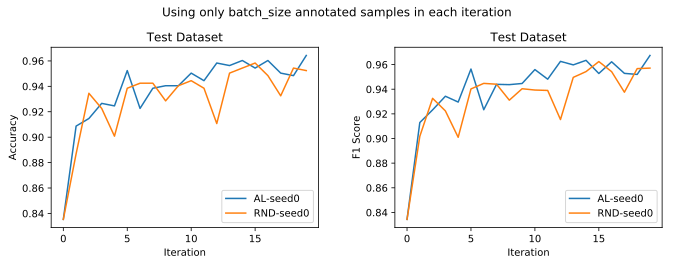

In [3]:
import pickle
# pickle.dump(strategy_results, open('strategy_results.pkl', 'wb'))
# AL_performance0 = pickle.load(open('uncertain_strategy_results.pkl', 'rb'))['uncertainty']
# RND_performance0 = pickle.load(open('random_strategy_results.pkl', 'rb'))['random']
import matplotlib.pyplot as plt

strategy_results = pickle.load(open('strategy_results.pkl', 'rb'))
AL_performance0 = strategy_results['uncertainty']
RND_performance0 = strategy_results['random']
# print(RND_performance0)
# print(AL_performance0)

plt.figure(figsize=(10,4))
plt.suptitle('Using only batch_size annotated samples in each iteration')
plt.subplot(121)
plt.plot(range(len(AL_performance0[0])-1), AL_performance0[0][:-1], label='AL-seed0')
plt.plot(range(len(RND_performance0[0])-1), RND_performance0[0][:-1], label='RND-seed0')
plt.title('Test Dataset')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(122)
plt.plot(range(len(AL_performance0[1])-1), AL_performance0[1][:-1], label='AL-seed0')
plt.plot(range(len(RND_performance0[1])-1), RND_performance0[1][:-1], label='RND-seed0')

plt.legend()
plt.title('Test Dataset')
plt.xlabel('Iteration')
plt.ylabel('F1 Score')


plt.tight_layout(pad=3.0)

%config InlineBackend.figure_format = 'svg'

# plt.savefig('Results-annotated_i.svg', format='svg')
plt.show()